# Plots for "Fundamental energy cost of finite-time parallelizable computing"
## Define Constants / Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
N = np.array([10 ** (exp / 5) for exp in range(0, 125)], dtype=np.float64) # number of operations
Ne = N
T = 1 # Temperature in K
cpu_T = 330 # CPU temperature in K
t = 1 # time in s

kT = 1.380649E-23 * T # Boltzmann constant times temperature
h = 6.62607015E-34 # Planck constant

a_nanomagnets = 1.1E-29 # estimate for energy efficiency constant "a" derived from [1]
a_electronic = 8E-7 * kT * t * cpu_T 
a_xeon = 2.3 * kT * t * cpu_T # estimate for energy efficiency constant "a" derived from [2]
b = 1 # parallelization constant b: 1/b determines the number of operations performed by each processor in the parallel computer
alpha =  1E6 * kT * t # proportionality constant determining the amount of leakage current for a given operating Voltage (see Supplementary section S4)
beta = 1E12 * kT * t # provisioning work (see Supplementary section S4)

xe_N = [1.09E9] # Number of operations per second for Xeon Phi [2]
xe = [1.4E-11 ] # Power consumption per operation for Xeon Phi [2]

kTunits = True
if kTunits:
    xe[0] = xe[0] / ( kT * cpu_T )

[1] Gaudenzi, R., Burzuri, E., Maegawa, S., van der Zant, H. S. J. & Luis, F. Quantum Landauer erasure with a molecular nanomagnet. Nature Phys. 14, 565 (2018).

[2] Shao, Y. S. & Brooks, D. Energy characterization and instruction-level energy model of Intel’s Xeon Phi processor. In International Symposium on Low Power Electronics and Design (ISLPED), 389–394 (2013).

## Base functions

In [2]:
def compare_serial_parallel(N=N, par=[0,1], a_s=[a_nanomagnets], b_s=[b], f_s=[np.log(2)], t=1, kTunits=kTunits):
    '''Calculate the energy consumption for ideal serial and parallel computers for a given number of operations.

    Corresponds to equations 3 and 4 in the text. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    par : list, optional
        degrees of parallelization, by default [0,1]
    a_s : list, optional
        energy efficiency constants a, by default [a_nanomagnets]
    b_s : list, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default [b]
    f_s : list, optional
        constant pre-factors, by default [np.log(2)]
    t : int, optional
        time in s, by default 1
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W = np.zeros((len(N), len(par) * len(a_s) * len(b_s) * len(f_s)))
    n = 0
    legend = []
    for a in a_s:
        for b in b_s:
            for f in f_s:
                for p in par:
                    W[:, n] = f * kT + a / (b * t) * ((1 - p) * np.sqrt(b * N) + np.sqrt(p)) ** 2
                    if kTunits:
                        W[:, n] = W[:, n] / kT
                    W[b * N < 1, n] = None
                    if p < 1:
                        W[(1-p) * N < 1, n] = None
                    legend.append('p:{}, a:{}, b:{}, f:{}'.format(p,a,b,f))
                    n += 1
    return (W, legend)

def fundamental_vs_extrapolated_from_xeon(N=N, b=b, t=1, T=cpu_T, kTunits=kTunits):
    '''Calculate energy consumption for serial and parallel computers. Assume fundamental limit for a is Planck's constant. Extrapolate a for electronic computers from Xeon Phi.

    Corresponds to equations 3 and 4 in the text. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    b : float, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default b
    T : float, optional
        CPU temperature of Xeon Phi in K, by default cpu_T
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W, legend = compare_serial_parallel(N=N, par=[0,1], a_s=[h], b_s=[b], t=t, kTunits=kTunits)
    W2, legend = compare_serial_parallel(N=N, par=[0,1], a_s=[a_xeon], b_s=[b], t=t, kTunits=kTunits)
    W2 = W2/T
    return np.hstack((W,W2))

def with_parallelization_overhead(N=N, a=a_nanomagnets, b=b, overhead=[0.05, 0.1, 1], t=1, kTunits=kTunits):
    '''Calculate energy consumption for given parallelization overheads.

    Corresponds to equations 7 and 9 in the text. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    a : float, optional
        energy efficiency constant a, by default a_nanomagnets
    b : float, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default b
    overhead : list, optional
        fraction of parallelization overhead, by default [0.05, 0.1, 1]
    t : float, optional
        time in s, by default 1
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W = np.zeros((len(N), len(overhead) + 2))
    W[:, 0:2], _ = compare_serial_parallel(N=N, par=[0,1], a_s=[a], b_s=[b], t=t, kTunits=kTunits)
    for n, c in enumerate(overhead):
        N_ove = c * b * N
        W[:, n + 2] = (1 + N_ove / N) * (np.log(2) * kT + a / (b * t) * (1 + N_ove / N))
        if kTunits:
            W[:, n + 2] = W[:, n + 2] / kT
    return W

def sci_notation(num, decimal_digits=0, precision=None, exponent=None):
    '''Returns a string representation of the scientific notation of the given number formatted for use with LaTeX or Mathtext, with specified number of significant decimal digits and precision (number of decimal digits to show). The exponent to be used can also be specified explicitly.'''
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits
    return r"{0:.{2}f}\cdot10^{{{1:d}}}".format(coeff, exponent, precision)

def plot_work_operations(N, W, w_factor=1, log=True, log_xticks=None, log_yticks=[1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18], legend=None, a=None, file_name=None):
    '''Plot work vs number of operations'''
    fig, ax = plt.subplots(figsize=(3.51, 3.36))
    if log:
        ax.set_yscale('log')
        ax.set_xscale('log')
    label_size=10
    W *= w_factor
    ax.tick_params(axis='both', which='major', labelsize=7, direction='in')
    plt.plot(N, W)
    plt.xlabel('$N$ (bit operations)', fontsize=label_size)
    plt.ylabel('$W/N$ ($kT$)', fontsize=label_size)
    plt.xlim([np.min(N), np.max(N)])
    y_min = np.nanmin(W)/10 if log else 0
    plt.ylim([y_min, np.nanmax(W)])
    if log:
        plt.xticks(log_xticks)
        plt.yticks(log_yticks)
        ax.tick_params(axis='both', which='minor', direction='in')
    if legend is not None:
        if a is not None:
            legend[-1] += '\n$a = {} kT$s'.format(sci_notation(a))
        plt.legend(legend, fontsize=8)
    plt.tight_layout(pad=0.0)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    return fig, ax


def plot_max_operations_power(P, N, log_yticks=[1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18, 1E21, 1E24, 1E27], file_name=None, **kw_args):
    '''Plot maximum number of operations vs maximum power limit'''
    fig, ax = plot_work_operations(P, N, log_yticks=log_yticks, file_name=None, **kw_args)
    label_size=10
    plt.ylabel('$N_\mathregular{max}$ (bit operations)', fontsize=label_size)
    plt.xlabel('$P_\mathregular{max}$ (watt)', fontsize=label_size)
    plt.ylim([1, np.max(N)])
    plt.xlim([np.min(P), np.max(P)])
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')


def annotate(legend, pos, rot, file_name, a=a_nanomagnets / kT, fs=8):
    '''Add annotations to figure'''
    if a is not None:
        if isinstance(a, str):
            ann = a
        else:
            ann = '$a = {} kT$s'.format(sci_notation(a))
        plt.annotate(ann, pos[-1], bbox=dict(boxstyle="round", fc="w", ec="0.8", lw=1, alpha=0.8), fontsize=fs)
    for i, t in enumerate(legend):
        plt.annotate(t, pos[i], rotation=rot[i], fontsize=fs)
    plt.savefig(file_name, bbox_inches='tight')


## Fig. 2. Finite-time Landauer bound for ideal serial and parallel computers

Parameters are $T = 1$ K, $b=1$ and $a=8\cdot10^{-7} kT$ s.

### Panel a) Energy consumption per operation $W/N$
for solving a fully parallelizable problem of size $N$ by an ideal
serial, Eq. (3) (blue), and parallel, Eq. (4) (orange), computer.
The energetic cost diverges with $N$ for an ideal serial com-
puter and remains constant for an ideal parallel computer.


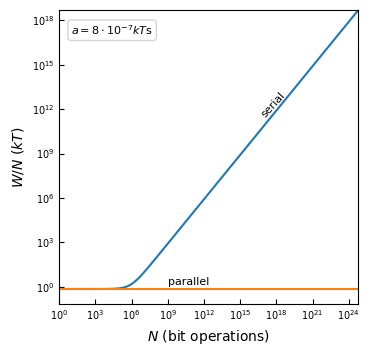

In [3]:
file_name = 's_p.svg'
W, _ = compare_serial_parallel()
plot_work_operations(N, W)
legend = ['serial', 'parallel']
rot = [48, 0]
pos=[(4E16, 3E11), (1E9, 1.2E0), (1E1, 1E17)]
annotate(legend, pos, rot, file_name)

### Panel b) Maximal number of bit operations $N_\text{max}^\text{ser}~N_\text{max}^\text{par}$
that can be performed by an ideal serial, Eq.(5) (blue), and parallel, Eq. (6) (orange), computer in the finite time $\mathcal{T} = 1$ s within a given power budget $P_\text{max}$.

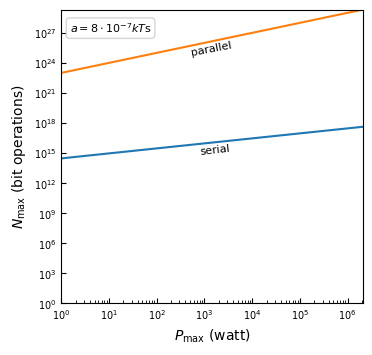

In [4]:
file_name='wmax_s_p.svg'
Pm = np.array([2**exp for exp in range(0, 22)], dtype=np.float64)

def max_energy(P=Pm, a=a_nanomagnets, b=b, t=1):
    N = np.zeros((len(P), 2))
    K = kT * np.log(2)
    B = a / t / b
    N[:, 0] = (np.sqrt(4 * a * P + K**2) - K)/(2 * a / t )
    N[:, 1] = P * t / (K + B)
    return N

Nm = max_energy(P=Pm)
plot_max_operations_power(Pm, Nm)
legend=['serial', 'parallel']
rot = [6.5, 11]
pos = [(8E2, 7E14), (5E2, 6E24), (1.5E0, 1E27)]
annotate(legend, pos, rot, file_name)

## Fig. 3 Fundamental limit and extrapolated energy cost per operation for ideal serial and parallel computers
Fundamental limits obtained for $a=h$ (Planck constant; $T=1K$) ({solid} lines) and extrapolated energy cost corresponding to $a = 2.3~kT$s (Xeon Phi; $T=330K$) (dashed lines) for ideal serial, Eq.~(3) (blue), and parallel, Eq.~(4) (orange), computers.  The measured value {for} a Xeon Phi processor  is represented by a black X. For reference, an energy cost of $1 $ J/operation is shown as a dash-dotted line. {Parameters are $\mathcal{T} = 1$~s and  $b=1$.

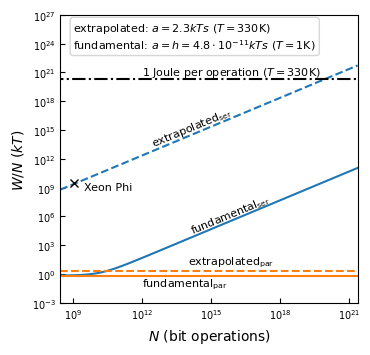

In [5]:
N_X = np.array([2**exp for exp in range(28, 72)], dtype=np.float64)
W = fundamental_vs_extrapolated_from_xeon(N=N_X, b=1)
file_name='fun_xeon.svg'
# print(N)
# print(W)
plot_work_operations(N_X, W, log=True, log_xticks=[1E9, 1E12, 1E15, 1E18, 1E21], log_yticks=[1E-3, 1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18, 1E21, 1E24, 1E27], file_name=file_name, w_factor=1)
plt.plot(xe_N, xe, 'xk')
plt.plot([1E7, 1E23], [1/(kT*330), 1/(kT*330)], '-.k')
plt.gca().lines[2].set_color(plt.gca().lines[0].get_color())
plt.gca().lines[3].set_color(plt.gca().lines[1].get_color())
for line in plt.gca().lines[2:4]:
    line.set_linestyle('--')
pos = [(1E14, 2E4), (2E12, 2E13), (1E12, 5E-2), (1E14, 1E1), (3E9, 6E8),(1E12, 5E20), (1E9, 3E23)]
legend = ['fundamental$_\mathregular{ser}$', 'extrapolated$_\mathregular{ser}$', 'fundamental$_\mathregular{par}$', 'extrapolated$_\mathregular{par}$', 'Xeon Phi', '1 Joule per operation ($T = 330$K)']
rot = [22.5, 22.5, 0, 0, 0, 0]
annotate(legend, pos, rot, file_name, a='extrapolated: $a = 2.3 kTs$ ($T = 330$K)\nfundamental: $a = h = 4.8\cdot10^{-11}kTs$ ($T = 1$K)')
plt.savefig(file_name, bbox_inches='tight')

## Fig. 4 Effects of not ideally parallelizable problems.

Same parameters as in Fig. 2.

### a) Energy cost per operation $W_\text{tot}^\text{com}/N$ for a partially parallelizable algorithm that has no overhead
Eq. (7).


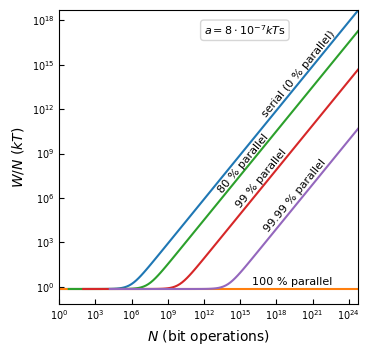

In [6]:
file_name='partial.svg'
par=[0, 1, 0.80, 0.99, 0.9999]
W, legend = compare_serial_parallel(par=par)
plot_work_operations(N, W)
rot = [50.5] * 5
rot[1] = 0
leg = ['{:g} % parallel'.format(x*100) for x in par]
legend=['serial (0 % parallel)'] + leg[1:]
pos = [(5E16, 3E11), (1E16, 1.2E0), (1E13, 2E6), (3E14, 2E5), (7E16, 5E3), (1E12, 1E17)]
annotate(legend, pos, rot, file_name)


###  b) Energy cost per operation $W_\text{tot}^\text{ove}/N$ for a fully parallel algorithm with linear overhead
$N_\text{ove}(n) = cn$, Eq. (9), and $c = 0-5000\%$.

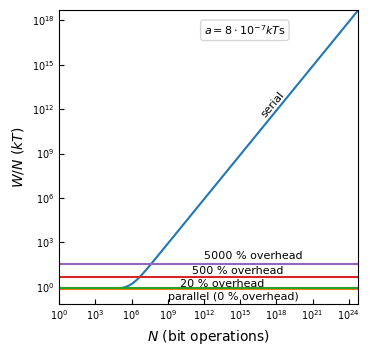

In [7]:
file_name='overhead.svg'
ov=[0.2, 5, 50]
leg = ['{:.0f} % overhead'.format(x*100) for x in ov]
W = with_parallelization_overhead(overhead=ov)
#print(W)
legend=['serial', 'parallel (0 % overhead)'] + leg
plot_work_operations(N, W, a=a_nanomagnets / kT)
rot = [0] * 5
rot[0] = 50
pos = [(4E16, 3E11), (1E9, 1.2E-1), (1E10, 9E-1), (1E11, 7E0), (1E12, 7E1), (1E12, 1E17)]
annotate(legend, pos, rot, file_name)

# Supplementary Information

## Base functions

In [8]:
def non_linear_overhead(N=N, a=a_nanomagnets, b=b, fun=[lambda x: 0.1 * x], t=1, kTunits=kTunits):
    '''Calculate energy consumption for given parallelization overhead functions.

    Corresponds to equation S7 and 9 in supplementary information. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    a : float, optional
        energy efficiency constant a, by default a_nanomagnets
    b : float, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default b
    fun : list, optional
        functions used to calculate overhead depending from problem size, by default [lambda x: 0.1 * x]
    t : float, optional
        time in s, by default 1
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W = np.zeros((len(N), len(fun) + 2))
    W[:, 0:2], __ = compare_serial_parallel(N=N, par=[0,1], a_s=[a], b_s=[b], t=t, kTunits=kTunits)
    for n, f in enumerate(fun):
        N_ove = f(N)
        W[:, n + 2] = (1 + N_ove / N) * (np.log(2) * kT + a / (b * t) * (1 + N_ove / N))
        if kTunits:
            W[:, n + 2] = W[:, n + 2] / kT
    return W

def non_ideal_computers(N=N, a=a_electronic, b=b, alpha=alpha, f=np.log(2), t=1, T=cpu_T, kTunits=kTunits):
    '''Calculate energy consumption for non-ideal electronic computers.

    Corresponds to equations S8 and S9 in the supplementary information. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    a : float, optional
        energy efficiency constant a, by default a_electronic
    b : float, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default b
    alpha : float, optional
        proportionality constant determining the amount of leakage current for a given operating Voltage (see Supplementary section S4), by default alpha
    t : float, optional
        time in s, by default 1
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W = np.zeros((len(N), 2))
    W[:, 0] = f * kT * T + a / (t ** 2) * N ** 2 + alpha
    W[:, 1] = f * kT * T + a / ((b * t) ** 2) + alpha
    if kTunits:
        W = W / (kT * T)
    return W

def non_ideal_computers_with_provisioning_overhead(N=N, a=a_electronic, b=b, alpha=alpha, beta=beta, f=np.log(2), t=1, kTunits=kTunits):
    '''Calculate energy consumption for non-ideal electronic computers.

    Corresponds to equations S8 and S9 in the supplementary information including provisioning work beta/N. Constants given as default values are defined in the constants section.

    Parameters
    ----------
    N : np.ndarray, optional
        numpy array with the given number of calculations, by default N
    a : float, optional
        energy efficiency constant a, by default a_electronic
    b : float, optional
        parallelization constants b: 1/b determines the number of operations performed by each processor in the parallel computer, by default b
    alpha : float, optional
        proportionality constant determining the amount of leakage current for a given operating Voltage (see Supplementary section S4), by default alpha
    beta : float, optional
        constant determining the amount of provisioning work needed for the parallel computer (see Supplementary section S4), by default beta
    t : float, optional
        time in s, by default 1
    kTunits : bool, optional
        describe energy in kT units, by default kTunits

    Returns
    -------
    np.ndarray
        energy consumptions for the given parameters and number of calculations, each row represents one number of calculations and each column represents one parameter set
    '''
    W = non_ideal_computers(N=N, a=a, b=b, alpha=alpha, f=f, t=t)
    W[:, 1] = f * kT * 330 + (a / ((b * t) ** 2)  + alpha + beta / N)
    if kTunits:
        W[:, 1] = W[:, 1] / (kT * 330)
    return W


## Fig. S1 Effects of different overhead behaviors. 
Energy cost per operation for a fully parallel algorithm with the given overhead function $N_\mathrm{ove}(n)$ in Eq. S7.  Parameters are $\mathcal{T} = 1$ s, $T = 1$ K, $b=1$ and $a = 8 \cdot 10^{-7}~kT$ s.

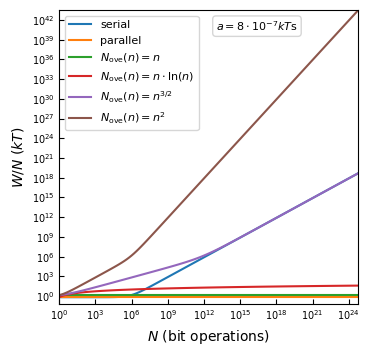

In [9]:
file_name='overhead_fun.svg'
prct = 1
ov=[lambda x: prct * x, lambda x: prct * x * np.log(x), lambda x: prct * x ** (3/2), lambda x: prct * x ** 2] #, lambda x: prct * x ** 3] # lambda x: prct * np.log(x), 
leg = ['n', 'n\cdot\ln(n)', 'n^{3/2}', 'n^2'] #, 'n^3'] # '\ln {n}', 
leg = ['$N_\mathrm{{ove}}(n) = {}$'.format(x) for x in leg]
W = non_linear_overhead(fun=ov)
plot_work_operations(Ne, W, log=True ,legend=['serial', 'parallel'] + leg, log_yticks=[1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18, 1E21, 1E24, 1E27, 1E30, 1E33, 1E36, 1E39, 1E42])
annotate(legend=[], pos=[(1E13,2E40)], rot=[], file_name=file_name)

## Fig. S2 Effect of different numbers of operations per parallel processor. 
Energy cost per operation for an ideal serial computer compared to ideal parallel computers with different numbers of processors.  Parameters are $\mathcal{T} = 1$ s, $T = 1$ K, $b=1, b=0.001, b=0.000001$ and $a = 8\cdot 10^{-7} kT$ s.

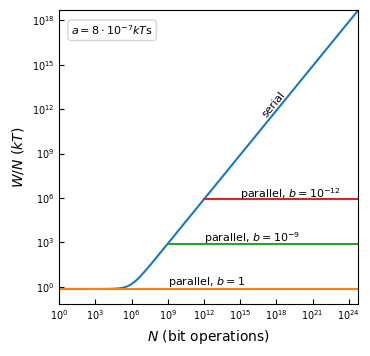

In [10]:
file_name='s_p_var_b.svg'
W, _ = compare_serial_parallel()
W2, _ = compare_serial_parallel(par=[1],b_s=[1E-9, 1E-12])
W3 = np.hstack((W,W2))
plot_work_operations(N, W3, file_name=file_name)
rot = [0] * 4
rot[0] = 50.5
legend=['serial', 'parallel, $b=1$', 'parallel, $b=10^{-9}$', 'parallel, $b=10^{-12}$']
pos = [(5E16, 3E11), (1E9, 1.2E0), (1E12, 1E3), (1E15, 1E6), (1E1, 1E17)]
annotate(legend, pos, rot, file_name)

## Fig. S3 Non-ideal computers.

Parameters: $T_\text{non-ideal} = 330~$K (a typical temperature for a CPU under load), $T_\text{optimal} = 1~$K, $\mathcal{T} = 1$~s, $a=8\cdot10^{-7} kT$s, $b=1$, $\alpha = 10^6~kT$s and $\beta = 10^{12} kT$s.

### a) 
Energy cost per operation for optimal (straight lines) and non-ideal (dashed lines) serial (blue, Eq.(S8)) and parallel (orange, Eq. (S9)) computers. 

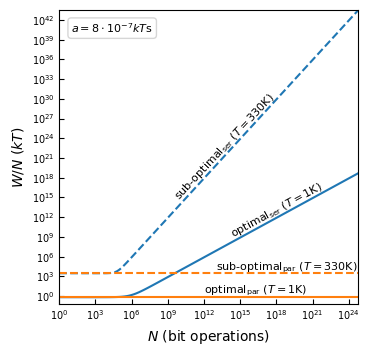

In [11]:
file_name = 'suboptimal.svg'
W, legend = compare_serial_parallel()
beta =  1E6 * kT
W2 = non_ideal_computers(alpha=beta)
W3 = np.hstack((W,W2))
plot_work_operations(Ne, W3, file_name=file_name, log_yticks=[1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18, 1E21, 1E24, 1E27, 1E30, 1E33, 1E36, 1E39, 1E42])
plt.gca().lines[2].set_color(plt.gca().lines[0].get_color())
plt.gca().lines[3].set_color(plt.gca().lines[1].get_color())
for line in plt.gca().lines[2:4]:
    line.set_linestyle('--')
pos = [(1E14, 1E9), (2E9, 5E14), (1E12, 3E0), (1E13, 1E4), (1E1, 1E40)]
legend = ['optimal$_\mathregular{ser}$ ($T = 1$K)', 'sub-optimal$_\mathregular{ser}$ ($T = 330$K)', 'optimal$_\mathregular{par}$ ($T = 1$K)', 'sub-optimal$_\mathregular{par}$ ($T = 330$K)']
rot = [28.5, 47, 0, 0]
annotate(legend, pos, rot, file_name)

### b) 
Same as a) except that the parallel computer includes provisioning work $W_\text{pro}(N, \mathcal{T})/N = \beta/N$.

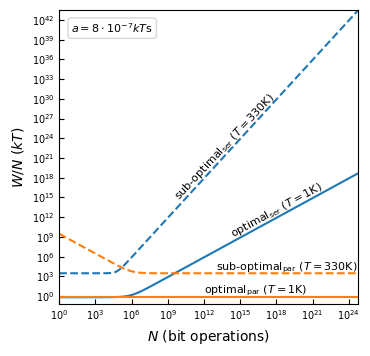

In [12]:
file_name = 'suboptimal_provisioning.svg'
W, legend = compare_serial_parallel()
gamma = 1E12 * kT
W2 = non_ideal_computers_with_provisioning_overhead(alpha=beta, beta=gamma)
W3 = np.hstack((W,W2))
plot_work_operations(Ne, W3, log_yticks=[1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18, 1E21, 1E24, 1E27, 1E30, 1E33, 1E36, 1E39, 1E42])
plt.gca().lines[2].set_color(plt.gca().lines[0].get_color())
plt.gca().lines[3].set_color(plt.gca().lines[1].get_color())
for line in plt.gca().lines[2:4]:
    line.set_linestyle('--')
legend=['optimal$_\mathregular{ser}$ ($T = 1$K)', 'optimal$_\mathregular{par}$ ($T = 1$K)', 'sub-optimal$_\mathregular{ser}$ ($T = 330$K)', 'sub-optimal$_\mathregular{par}$ ($T = 330$K)']
rot=[28.5, 0, 47, 0]
pos = [(1E14, 1E9), (1E12, 3E0), (2E9, 7E14), (1E13, 1E4), (1E1, 1E40)]
annotate(legend, pos, rot, file_name)

## Fig. S4 Finite-time bound for reversible and irreversible ideal serial and parallel computers.  
Energy consumption per operation, $W/N$, for solving a fully parallelizable problem of size $N$ by ideal serial, Eq. (3) (blue, green), and parallel, Eq. (4) (orange, red), computers operating irreversibly (blue, orange) or reversibly (green, red). The difference between ideal  reversible and irreversible computers is a constant $k T \ln 2$. On the other hand, for ideal serial computers, the difference becomes negligible for anything but very small operation frequencies. Same parameters as in Fig. (S1).

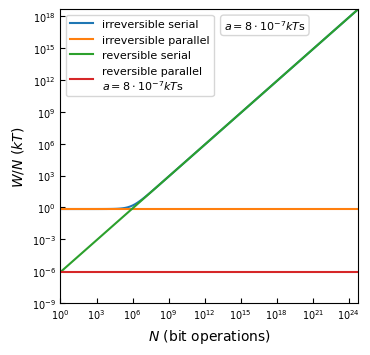

In [13]:
file_name='s_p_irreversible.svg'
W, _ = compare_serial_parallel(f_s=[np.log(2),0])
legend=['irreversible serial', 'irreversible parallel', 'reversible serial', 'reversible parallel']
plot_work_operations(N, W, legend=legend, file_name=file_name, log_yticks=[1E-9, 1E-6, 1E-3, 1E0, 1E3, 1E6, 1E9, 1E12, 1E15, 1E18], a=a_nanomagnets / kT)
annotate(legend=[], pos=[(4E13, 5E16)], rot=[], file_name=file_name)